In [ ]:
# pip install ydata_profiling

# Reading data and make them ready to work

In [ ]:
import pandas as pd
# from ydata_profiling import ProfileReport

donor_df = pd.read_csv("BenefactorsData.csv")
# donor_profile = ProfileReport(donor_df, title = "Donors Data")
# donor_profile.to_file("Donors Data Profile.html")

payment_df = pd.read_csv("TransactionalData.csv")
# payment_profile = ProfileReport(payment_df, title = "Payments Transactions")
# payment_profile.to_file("Payments Data Profile.html")

In [ ]:
donor_df.info()
payment_df.info()

Merge datasets

In [ ]:
merged_df = pd.merge(donor_df, payment_df, on="UserID")
merged_df.to_csv("merged_dataset.csv")

Add summary data to Donor Dataset

In [ ]:
# Calculate the number of records and sum of payments for each UserID in the Payment dataset
payment_summary = payment_df.groupby('UserID').agg(
    NumPayments=('TransID', 'count'),
    TotalPayment=('PaymentAmount', 'sum')
).reset_index()

# Merge the summary back into the Donor dataset
donor_df = donor_df.merge(payment_summary, on='UserID', how='left')

# Group by SupportType and calculate number of payments and total payments
summary_dataset = payment_df.groupby('SupportType').agg({
    'TransID': 'count',  # Number of payments
    'PaymentAmount': 'sum'  # Total payments
}).reset_index()

# Rename columns for clarity
summary_dataset.rename(columns={'TransID': 'NumberOfPayments', 'PaymentAmount': 'TotalPayments'}, inplace=True)

print(summary_dataset)
#print(donor_df)

# Check the dependency between Gender and number of payments and total payments

In [ ]:
# Find the 10 greatest values for NumPayments
top_num_payments = donor_df.nlargest(20, 'NumPayments')
print("Top 10 NumPayments:")
print(top_num_payments)

# Find the 10 greatest values for TotalPayment
top_total_payments = donor_df.nlargest(20, 'TotalPayment')
print("\nTop 10 TotalPayment:")
print(top_total_payments)

In [ ]:
from scipy.stats import ttest_ind
import numpy as np

# Remove nan values
donor_df = donor_df.dropna(subset=['Gender', 'NumPayments', 'TotalPayment'])

# Coding gender values
# donor_df['GenderNumeric'] = donor_df['Gender'].map({'M': 1, 'F': 2})

# print(donor_df)


male_data = donor_df[donor_df['Gender'] == 'مرد']
female_data = donor_df[donor_df['Gender'] == 'زن']
# male_data.info()
# Perform t-tests for NumPayments and TotalPayment
num_payments_test = ttest_ind(male_data['NumPayments'], female_data['NumPayments'], equal_var=False)
total_payment_test = ttest_ind(male_data['TotalPayment'], female_data['TotalPayment'], equal_var=False)

# Print results
print("T-test for NumPayments (Gender Dependency):")
print(f"Statistic: {num_payments_test.statistic}, p-value: {num_payments_test.pvalue}")

print("\nT-test for TotalPayment (Gender Dependency):")
print(f"Statistic: {total_payment_test.statistic}, p-value: {total_payment_test.pvalue}")

# Result
# T-test for NumPayments (Gender Dependency):
# Statistic: 20.404277170355236, p-value: 1.8268465392917694e-92
# T-test for TotalPayment (Gender Dependency):
# Statistic: 4.543933993934602, p-value: 5.524716571142883e-06

# There is a significant relationship between gender and NumPayments
# There is a significant relationship between gender and TotalPayment

# Visualize the result

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
#sns.set(style="whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for NumPayments by Gender
sns.boxplot(data=donor_df, x='Gender', y='NumPayments', ax=axes[0])
axes[0].set_title("NumPayments by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("NumPayments")

# Boxplot for TotalPayment by Gender
sns.boxplot(data=donor_df, x='Gender', y='TotalPayment', ax=axes[1])
axes[1].set_title("TotalPayment by Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("TotalPayment")

# Show the plots
#plt.tight_layout()
plt.show()

In [ ]:
# Group by Gender and calculate the mean of NumPayments and TotalPayment
group_stats = donor_df.groupby('Gender').agg({
    'NumPayments': 'mean',
    'TotalPayment': 'mean'
}).reset_index()

print(group_stats)

# Profiling donor's characteristics based on different variables

In [ ]:
# Helper function to create pie charts
def plot_pie_chart(data, column, values, title, colors=None):
    plt.figure(figsize=(8, 8))
    plt.pie(
        data[values],
        labels=data[column],
        autopct='%1.1f%%',
        startangle=140,
        colors=colors
    )
    plt.title(title)
    plt.show()

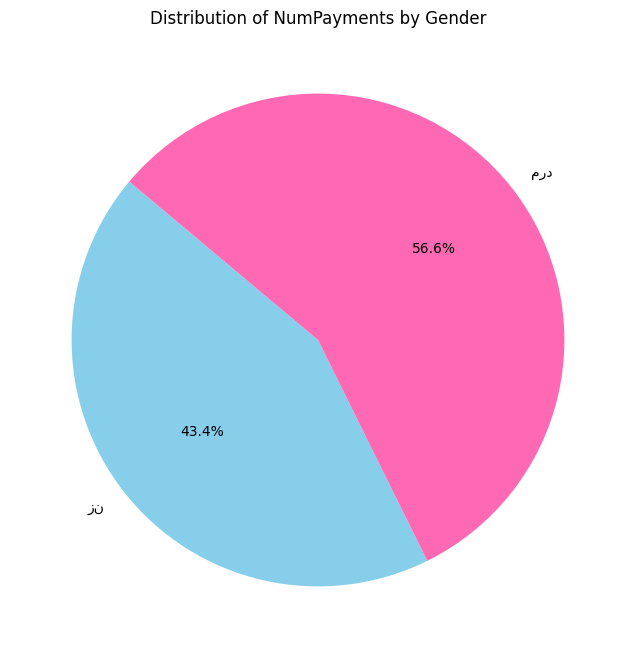

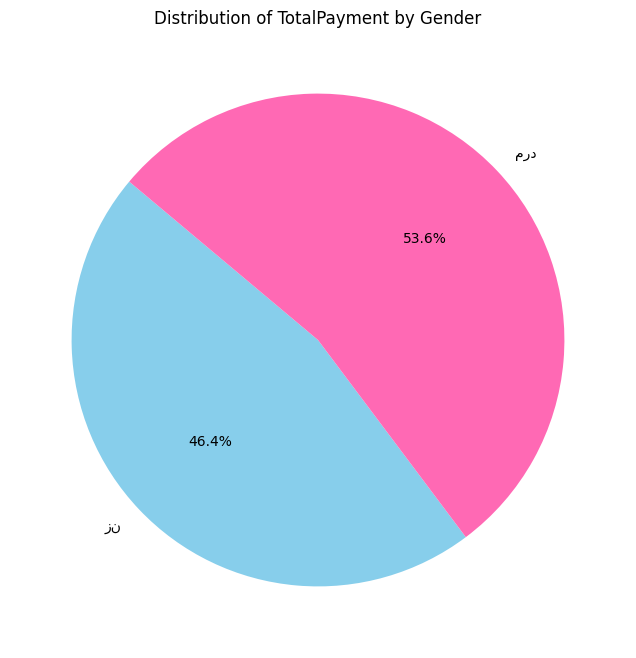

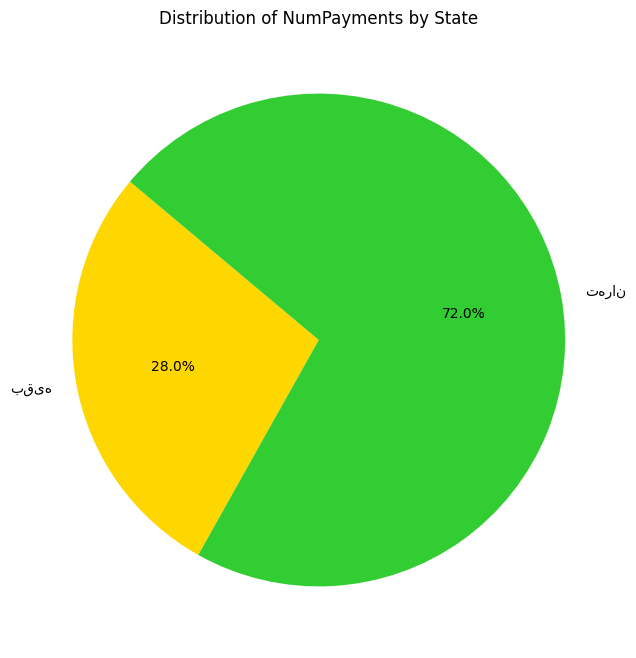

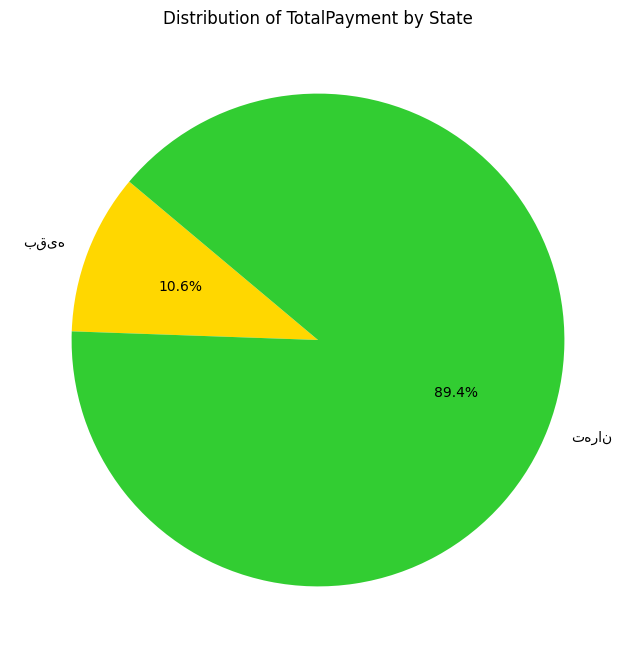

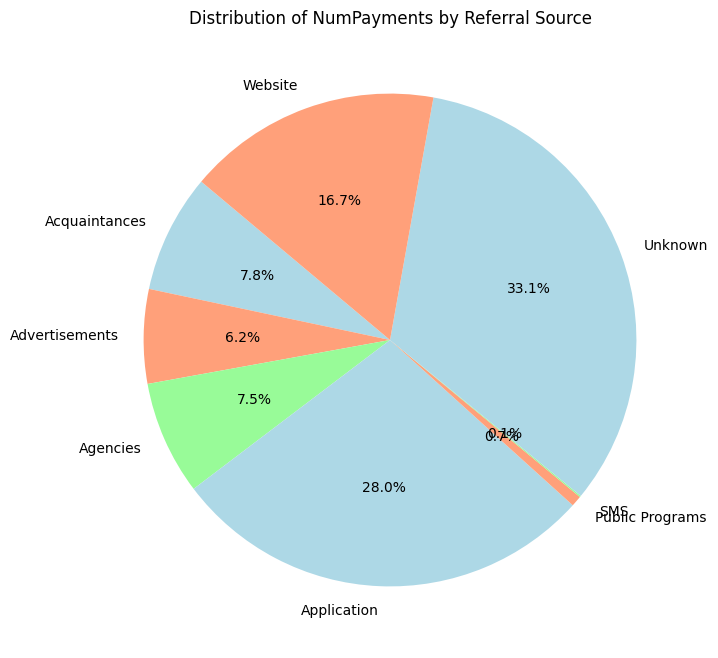

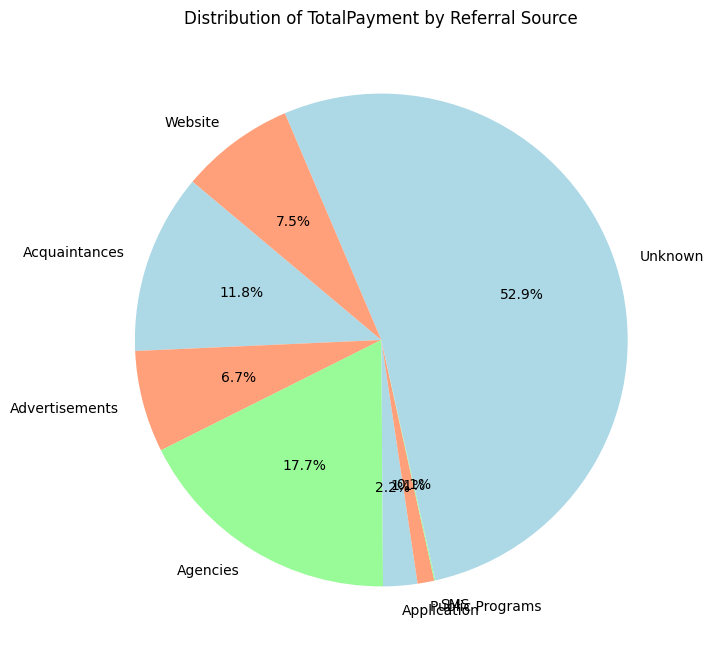

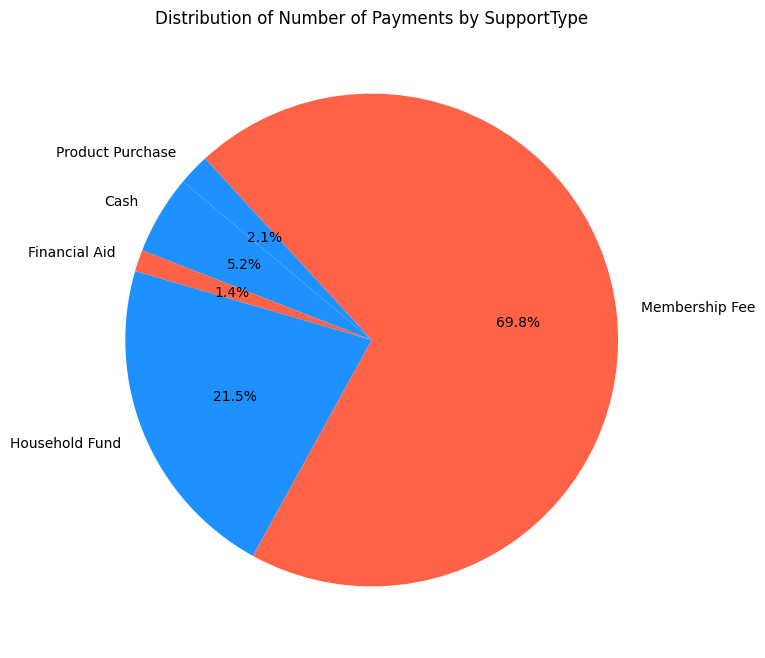

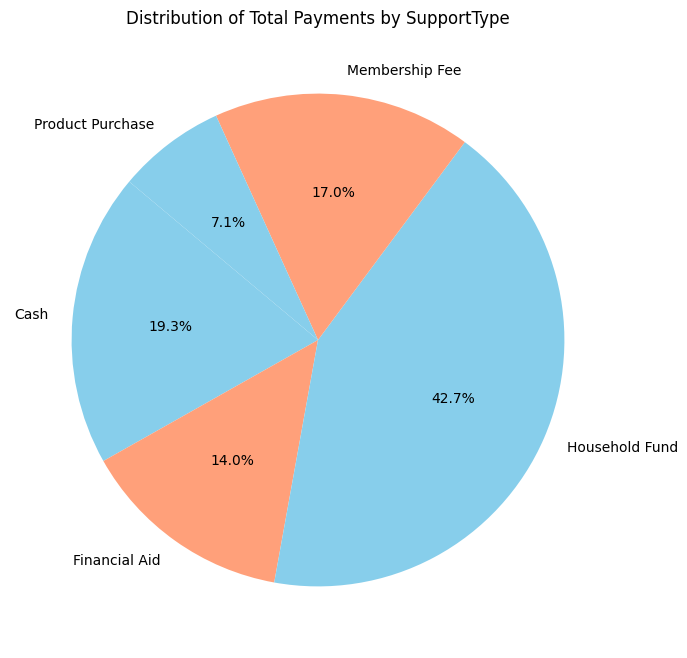

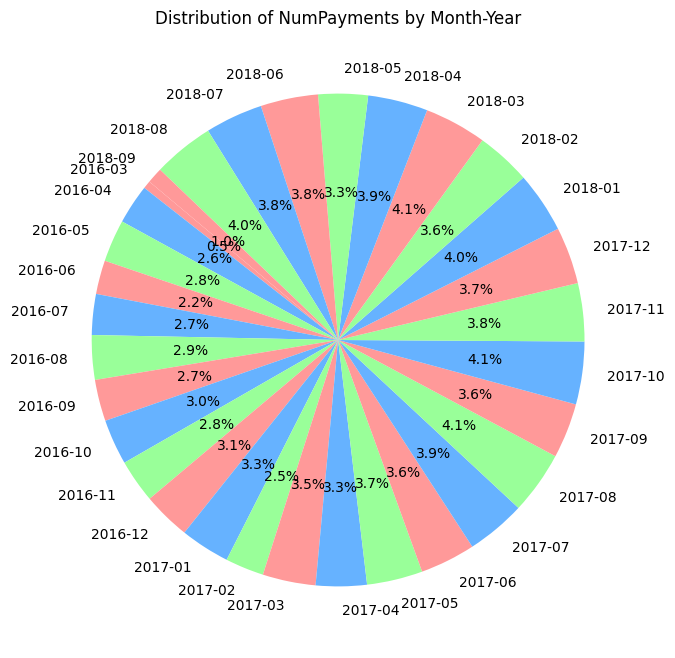

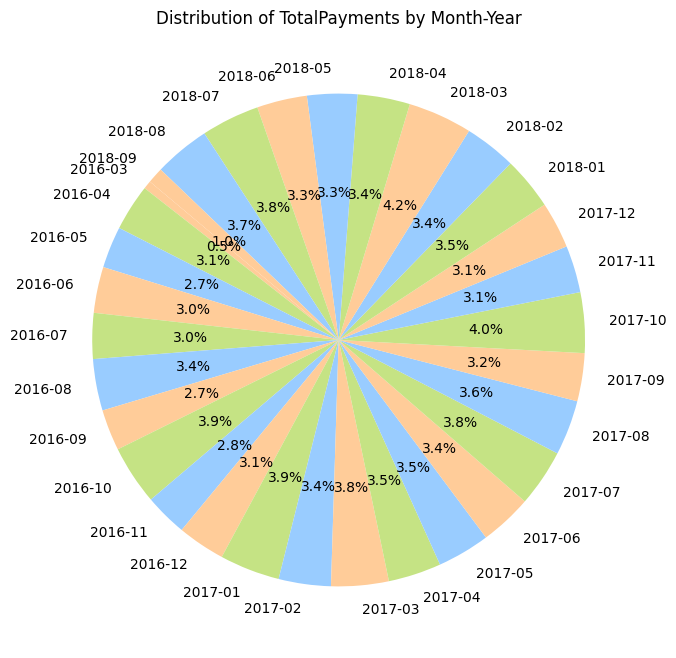

In [25]:
# Profiling: Gender statistics
gender_profile = donor_df.groupby('Gender').agg({
    'NumPayments': 'mean',
    'TotalPayment': 'mean'
}).reset_index()

# Profiling: State statistics
# Define the specific state to isolate, e.g., 'CA'
tehran_state = 'تهران'

# Create a new column to categorize into 'State1' and 'Others'
donor_df['StateCategory'] = donor_df['State'].apply(lambda x: 'تهران' if x == tehran_state else 'بقیه')

# Summarize the dataset by the new StateCategory
state_profile = donor_df.groupby('StateCategory').agg({
    'NumPayments': 'sum',
    'TotalPayment': 'sum'
}).reset_index()
# state_profile = donor_df.groupby('State').agg({
#     'NumPayments': 'sum',
#     'TotalPayment': 'sum'
# }).reset_index()

# Profiling: Referral Source
Refer_profile = donor_df.groupby('ReferralSource').agg({
    'NumPayments': 'sum',
    'TotalPayment': 'sum'
}).reset_index()

# Convert PaymentDate to datetime format
payment_df['PaymentDate'] = pd.to_datetime(payment_df['PaymentDate'])
payment_df['MonthYear'] = payment_df['PaymentDate'].dt.strftime('%Y-%m')

# Group by Month-Year and summarize NumPayments and TotalPayments
summary_by_month_year = payment_df.groupby('MonthYear').agg({
    'TransID': 'count',  # Number of payments
    'PaymentAmount': 'sum'  # Total payments
}).reset_index()

# Rename columns for clarity
summary_by_month_year.rename(columns={'TransID': 'NumPayments', 'PaymentAmount': 'TotalPayments'}, inplace=True)

# Display the summary dataset
# print(summary_by_month_year)


# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# sns.boxplot(data=payment_df, x='MonthYear', y='NumPayments', ax=axes[0])
# axes[0].set_title("NumPayments by month-year")
# axes[0].set_xlabel("MonthYear")
# axes[0].set_ylabel("NumPayments")

# sns.boxplot(data=donor_df, x='MonthYear', y='TotalPayment', ax=axes[1])
# axes[1].set_title("TotalPayment by month-year")
# axes[1].set_xlabel("MonthYear")
# axes[1].set_ylabel("TotalPayment")



# # plt.tight_layout()
plt.show()

# # Visualizing State profile: Bar charts
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# sns.barplot(data=state_profile, x='State', y='NumPayments', ax=axes[0])
# axes[0].set_title("Total NumPayments by State")
# axes[0].set_xlabel("State")
# axes[0].set_ylabel("Total NumPayments")

# sns.barplot(data=state_profile, x='State', y='TotalPayment', ax=axes[1])
# axes[1].set_title("Total Payment Amount by State")
# axes[1].set_xlabel("State")
# axes[1].set_ylabel("Total Payment Amount")

# plt.tight_layout()
# plt.show()

# # Visualizing Referral profile: Bar charts
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# sns.barplot(data=Refer_profile, x='ReferralSource', y='NumPayments', ax=axes[0])
# axes[0].set_title("Total NumPayments by ReferralSource")
# axes[0].set_xlabel("ReferralSource")
# axes[0].set_ylabel("Total NumPayments")

# sns.barplot(data=Refer_profile, x='ReferralSource', y='TotalPayment', ax=axes[1])
# axes[1].set_title("Total Payment Amount by ReferralSource")
# axes[1].set_xlabel("ReferralSource")
# axes[1].set_ylabel("Total Payment Amount")

# # plt.tight_layout()
# plt.show()

# **************************************************************
# Plotting Number of Payments by Gender (Pie Chart)
plot_pie_chart(
    data=gender_profile,
    column='Gender',
    values='NumPayments',
    title='Distribution of NumPayments by Gender',
    colors=['#87CEEB', '#FF69B4']  # Male: Blue, Female: Pink
)

plot_pie_chart(
    data=gender_profile,
    column='Gender',
    values='TotalPayment',
    title='Distribution of TotalPayment by Gender',
    colors=['#87CEEB', '#FF69B4']
)

# State Profile
# state_profile = donor_df.groupby('State').agg({
#     'NumPayments': 'sum',
#     'TotalPayment': 'sum'
# }).reset_index()

plot_pie_chart(
    data=state_profile,
    column='StateCategory',
    values='NumPayments',
    title='Distribution of NumPayments by State',
    colors=['#FFD700', '#32CD32', '#FF4500']  # Gold, Green, Orange
)

plot_pie_chart(
    data=state_profile,
    column='StateCategory',
    values='TotalPayment',
    title='Distribution of TotalPayment by State',
    colors=['#FFD700', '#32CD32', '#FF4500']
)

plot_pie_chart(
    data=Refer_profile,
    column='ReferralSource',
    values='NumPayments',
    title='Distribution of NumPayments by Referral Source',
    colors=['#ADD8E6', '#FFA07A', '#98FB98']  # Light Blue, Salmon, Light Green
)

plot_pie_chart(
    data=Refer_profile,
    column='ReferralSource',
    values='TotalPayment',
    title='Distribution of TotalPayment by Referral Source',
    colors=['#ADD8E6', '#FFA07A', '#98FB98']
)

# # Plotting Number of Payments by SupportType (Pie Chart)
# plt.figure(figsize=(8, 8))
# plt.pie(
#     summary_dataset['NumberOfPayments'],
#     labels=summary_dataset['SupportType'],
#     autopct='%1.1f%%',
#     startangle=140,
#     colors=['#87CEFA', '#FF7F50']  # Colors for the slices
# )
# plt.title("Distribution of Number of Payments by SupportType")
# plt.show()

# # Plotting Total Payments by SupportType (Pie Chart)
# plt.figure(figsize=(8, 8))
# plt.pie(
#     summary_dataset['TotalPayments'],
#     labels=summary_dataset['SupportType'],
#     autopct='%1.1f%%',
#     startangle=140,
#     colors=['#FFD700', '#32CD32']  # Colors for the slices
# )
# plt.title("Distribution of Total Payments by SupportType")
# plt.show()

# Visualizing Number of Payments by SupportType
plot_pie_chart(
    data=summary_dataset,
    column='SupportType',
    values='NumberOfPayments',
    title='Distribution of Number of Payments by SupportType',
    colors=['#1E90FF', '#FF6347']  # Blue for Recurring, Red for One-time
)

# Visualizing Total Payments by SupportType
plot_pie_chart(
    data=summary_dataset,
    column='SupportType',
    values='TotalPayments',
    title='Distribution of Total Payments by SupportType',
    colors=['#87CEEB', '#FFA07A']  # Light Blue for Recurring, Light Salmon for One-time
)

# Pie chart for NumPayments by MonthYear
plot_pie_chart(
    data=summary_by_month_year,
    column='MonthYear',
    values='NumPayments',
    title='Distribution of NumPayments by Month-Year',
    colors=['#FF9999', '#66B2FF', '#99FF99']  # Custom colors for each month
)

# Pie chart for TotalPayments by MonthYear
plot_pie_chart(
    data=summary_by_month_year,
    column='MonthYear',
    values='TotalPayments',
    title='Distribution of TotalPayments by Month-Year',
    colors=['#FFCC99', '#C5E384', '#99CCFF']  # Custom colors for each month
)
# print("Gender Profile:")
# print(gender_profile)

# print("\nState Profile:")
# print(state_profile)